In [1]:
import sys
sys.path.append("../../../sampler-comparison")
sys.path.append("../../../sampler-evaluation")
sys.path.append("../../../../src/inference-gym/spinoffs/inference_gym")
sys.path.append("../../../../blackjax")
import os
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../../../blackjax')
sys.path.append('../sampler-comparison')
sys.path.append('../../../sampler-evaluation')
sys.path.append('../../../')
sys.path.append("../../../../src/inference-gym/spinoffs/inference_gym")
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sampler_evaluation
from sampler_comparison.samplers import samplers
import seaborn as sns
from functools import partial
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error
from sampler_comparison.samplers.hamiltonianmontecarlo.hmc import adjusted_hmc
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc


from sampler_comparison.samplers.general import make_log_density_fn
import blackjax
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error

import numpy as np
import jax
import jax.numpy as jnp
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import blackjax
from blackjax.util import run_inference_algorithm
import blackjax

from blackjax.adaptation.unadjusted_alba import unadjusted_alba
from blackjax.adaptation.unadjusted_step_size import robnik_step_size_tuning
from blackjax.adaptation.unadjusted_alba import unadjusted_alba
import math
from blackjax.mcmc.adjusted_mclmc_dynamic import make_random_trajectory_length_fn
from functools import partial
from blackjax.adaptation.step_size import bisection_monotonic_fn
from blackjax.util import thin_algorithm
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc_no_tuning

def compose(f, g):
    return lambda x: f(g(x))


def blackjax_las(model, num_chains, key, ndims, num_adjusted_steps, diagonal_preconditioning=True, target_acceptance_rate=0.8, target_eevpd=5e-4):

    init_key, tune_key, unadjusted_key, adjusted_key = jax.random.split(key, 4)
    initial_position = jax.random.normal(init_key, (ndims,))

    logdensity_fn = make_log_density_fn(model)
    ### Phase 1: unadjusted ###


    jax.debug.print("target_eevpd {x}", x=target_eevpd)
        
    # burn-in and adaptation
    num_alba_steps = 10000
    warmup = unadjusted_alba(
        algorithm=blackjax.mclmc, 
        logdensity_fn=logdensity_fn, integrator=blackjax.mcmc.integrators.isokinetic_mclachlan, 
        target_eevpd=target_eevpd, 
        v=1, 
        num_alba_steps=num_alba_steps,
        preconditioning=diagonal_preconditioning,
        alba_factor=0.4,
        )

    (blackjax_state_after_tuning, blackjax_mclmc_sampler_params), adaptation_info = warmup.run(tune_key, initial_position, 20000)

    # sampling
    ess_per_sample = blackjax_mclmc_sampler_params['ESS']
    print(f"ESS per sample according to tuning: {ess_per_sample}")

    num_steps = math.ceil(num_chains // ess_per_sample)

    alg = blackjax.mclmc(
            logdensity_fn=logdensity_fn,
            L=blackjax_mclmc_sampler_params['L'],
            step_size=blackjax_mclmc_sampler_params['step_size'],
            inverse_mass_matrix=blackjax_mclmc_sampler_params['inverse_mass_matrix'],
            integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        )

    thinning_rate = math.ceil(1/ess_per_sample)

    jax.debug.print("thinning_rate {x}", x=thinning_rate)

    alg = thin_algorithm(
                    alg,
                    thinning=thinning_rate,
                    info_transform=lambda info: jax.tree.map(jnp.mean, info),
                    )

    


    final_output, (history) = run_inference_algorithm(
            rng_key=unadjusted_key,
            initial_state=blackjax_state_after_tuning,
            inference_algorithm=alg,
            num_steps=num_chains,
            # num_steps=num_chains*thinning_rate,
            transform=lambda a, b: a,
            progress_bar=False,
        )
    samples = history.position # [::thinning_rate]
    # jax.debug.print("shape of samples {x}", x=samples.shape)

    # adjusted_num_grads_per_step = 2 * num_adjusted_steps
    # subsamples = samples[::thinning_rate]
    unadjusted_num_grads_per_step = 2 * thinning_rate
    subsamples = samples[::10]
    # jax.debug.print("shape of subsamples {x}", x=subsamples.shape)
    # raise Exception("stop here")

    integration_steps_fn = make_random_trajectory_length_fn(True)



    def make_mams_step(key):
        def mams_step(inp):

            step_size, positions, info, step_size_adaptation_state = inp
            # jax.debug.print("step_size {step_size}", step_size=(step_size, blackjax_mclmc_sampler_params['L']))
            num_steps_per_traj = 15 # blackjax_mclmc_sampler_params['L'] / step_size
            
            keys = jax.random.split(key, positions.shape[0])
            alg = blackjax.adjusted_mclmc_dynamic(
                    logdensity_fn=logdensity_fn,
                    step_size=step_size,
                    integration_steps_fn=integration_steps_fn(num_steps_per_traj),
                    integrator=blackjax.mcmc.integrators.isokinetic_velocity_verlet,
                    inverse_mass_matrix=blackjax_mclmc_sampler_params['inverse_mass_matrix'],
                    L_proposal_factor=jnp.inf,
                )
            

            def step_fn(pos_key):
                pos, key = pos_key
                init_key, run_key = jax.random.split(key, 2)
                state, info = alg.step(
                    rng_key=run_key,
                    state=blackjax.adjusted_mclmc_dynamic.init(pos, logdensity_fn, init_key),
                )
                return state, info
            
            new_states, infos = jax.lax.map(step_fn, xs=(positions,keys))
            # jax.debug.print("num_integration_steps {x}", x=infos.num_integration_steps)
            return (step_size, new_states.position, infos, step_size_adaptation_state)

        return mams_step
        
    epsadap_update = bisection_monotonic_fn(target_acceptance_rate)
    step_size_adaptation_state_initial = (jnp.array([-jnp.inf, jnp.inf]), False)
        
    def tuning_step(inp):

        old_step_size, old_positions, old_infos, step_size_adaptation_state = inp
        acc_rate = old_infos.acceptance_rate.mean()
        # jax.debug.print("acc_rate {x}", x=old_infos.acceptance_rate)

        
        step_size_adaptation_state, new_step_size = epsadap_update(
            step_size_adaptation_state,
            old_step_size,
            acc_rate,
        )
        
        return (new_step_size, old_positions, old_infos, step_size_adaptation_state)

    def step_fn(inp, key):
        results =  make_mams_step(key)(inp)
        tuned_params = tuning_step(results)
        return tuned_params, tuned_params
    
    initial_adjusted_key, adjusted_key = jax.random.split(adjusted_key, 2)

    _, _, infos, _ = make_mams_step(initial_adjusted_key)((0.0, subsamples, None, step_size_adaptation_state_initial))

    positions = subsamples
    step_size = blackjax_mclmc_sampler_params['step_size']

    _, (step_sizes, positions, infos, step_size_adaptation_state) = jax.lax.scan(step_fn, (step_size, subsamples, infos, step_size_adaptation_state_initial), jax.random.split(adjusted_key, num_adjusted_steps))

    # print(infos.num_integration_steps.shape, "num_integration_steps")
    adjusted_num_grads_per_step = infos.num_integration_steps.sum(axis=1)
    # print(adjusted_num_grads_per_step.shape, "adjusted_num_grads_per_step")

    return samples, positions, infos, num_steps, step_size_adaptation_state, step_sizes, unadjusted_num_grads_per_step, adjusted_num_grads_per_step


def las(num_adjusted_steps, num_chains, diagonal_preconditioning=True, target_acceptance_rate=0.8, target_eevpd=5e-4):

    def s(model, key):
        unadjusted_position, adjusted_position, infos, num_steps_unadjusted, step_size_adaptation_state, step_sizes, unadjusted_num_grads_per_step, adjusted_num_grads_per_step = blackjax_las(
            model=model,
            key=key,
            ndims=model.ndims,
            num_adjusted_steps=num_adjusted_steps,
            num_chains=num_chains,
            diagonal_preconditioning=diagonal_preconditioning,
            target_acceptance_rate=target_acceptance_rate,
            target_eevpd=target_eevpd
        )
        
        return unadjusted_position, adjusted_position, infos, num_steps_unadjusted, step_sizes, unadjusted_num_grads_per_step, adjusted_num_grads_per_step
        
    return s


2025-11-19 07:50:47.812627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763567447.968405   15309 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763567448.009534   15309 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-19 07:50:48.373033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = stochastic_volatility_mams_paper
# model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')



In [3]:
# run las on banana
# num_steps1 = 1000
num_adjusted_steps = 500
num_chains = 1000
diagonal_preconditioning = True
print("running las")
# sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning, target_eevpd=2e-8)
sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning, target_eevpd=1e-1)
unadjusted_samples, adjusted_samples, infos, num_steps_unadjusted, step_sizes, unadjusted_num_grads_per_step, adjusted_num_grads_per_step = sampler(model, key=jax.random.key(1))
# unadjusted_samples = sampler(model, key=jax.random.key(0))
# print(samples)
# print(samples.shape)



running las
target_eevpd 0.10000000149011612
ESS per sample according to tuning: 0.007233461830765009
thinning_rate 139


In [4]:
# infos.num_integration_steps.mean(axis=-1)

In [5]:
unadjusted_samples = jax.vmap(model.default_event_space_bijector)(unadjusted_samples)
adjusted_samples = jax.vmap(jax.vmap(model.default_event_space_bijector))(adjusted_samples)

In [46]:
# adjusted_num_grads_per_step

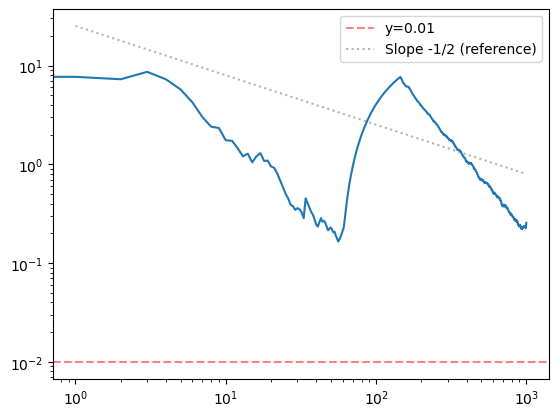

In [6]:
unadjusted_error_at_each_step = get_standardized_squared_error(
    unadjusted_samples[None, :, :], 
    f=model.sample_transformations["square"].fn,
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.max
    )[0]

plt.plot(unadjusted_error_at_each_step)
plt.yscale('log')
plt.xscale('log')
# horizontal line at y=0.01
plt.axhline(y=0.01, color='red', linestyle='--', alpha=0.5, label='y=0.01')
# -1/2 power law line
x_vals = np.linspace(1, unadjusted_error_at_each_step.shape[0], 500)
y_ref = (x_vals / x_vals[0])**(-0.5) * unadjusted_error_at_each_step[0]  # anchor at first point
plt.plot(x_vals, y_ref, color='gray', linestyle=':', alpha=0.6, label='Slope -1/2 (reference)')
plt.legend()
plt.show()


In [7]:
# effective sample size
# import sampler_evaluation
from blackjax.diagnostics import effective_sample_size
ess = effective_sample_size(unadjusted_samples[None, :, :])
ess.shape
ess.mean()

Array(672.475, dtype=float32)

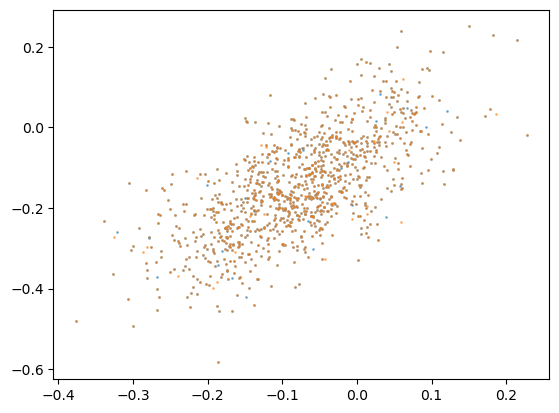

In [77]:
# unadjusted_samples[:, 1]
plt.scatter(unadjusted_samples[:, 0], unadjusted_samples[:, 1], alpha=0.5, label='unadjusted', s=1.0)
plt.scatter(adjusted_samples[0, :, 0], adjusted_samples[0, :, 1], alpha=0.5, label='adjusted', s=1.0)

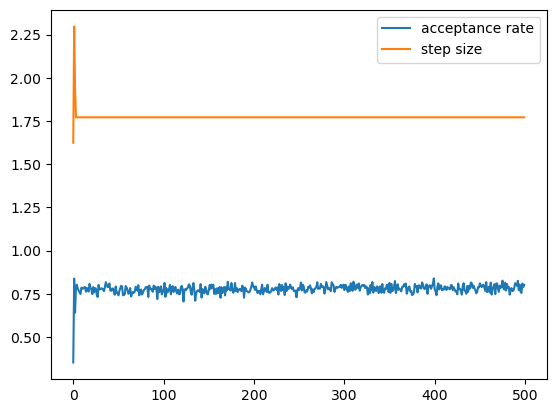

In [8]:
# print(unadjusted_samples[-1])

plt.plot(infos.acceptance_rate.mean(axis=1), label='acceptance rate')
# plt.plot(infos.num_integration_steps.mean(axis=1), label='num integration steps')
plt.plot(step_sizes, label='step size')
plt.legend()
plt.show()

In [9]:
# adjusted_error_at_each_step = ((((adjusted_samples**2) - model.sample_transformations["square"].ground_truth_mean[None, :])**2)/(model.sample_transformations["square"].ground_truth_standard_deviation[None, :]**2)).mean(axis=-1)


# adjusted_error_at_each_step_single = ((((unadjusted_samples**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2)/(model.sample_transformations["square"].ground_truth_standard_deviation**2))


fun = lambda i : ((((model.sample_transformations["square"].ground_truth_mean -  (adjusted_samples[i]**2).mean(axis=[0])))**2 ) / (model.sample_transformations["square"].ground_truth_standard_deviation**2))

adjusted_errs = jax.vmap(fun)(jnp.arange(adjusted_samples.shape[0])).max(axis=-1)


(100, 2429)

In [10]:
# adjusted_num_grads_per_step

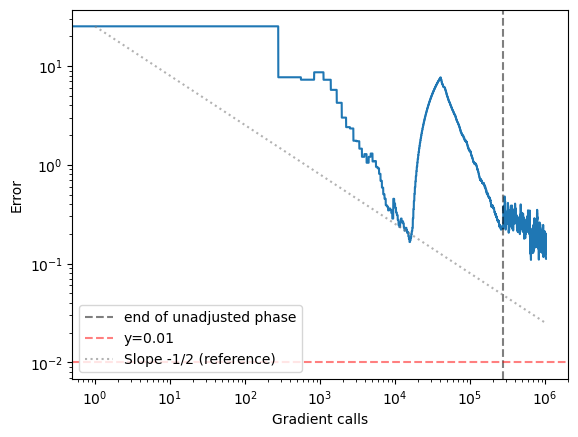

In [11]:
unadjusted_error_at_each_grad = np.repeat(unadjusted_error_at_each_step, unadjusted_num_grads_per_step)
adjusted_error_at_each_grad = np.repeat(adjusted_errs, jnp.ceil(adjusted_num_grads_per_step).astype(jnp.int32))

drop_first_n_steps = 0
# plt.plot(np.concatenate([unadjusted_error_at_each_step[drop_first_n_steps:], adjusted_errs[:]]))
plt.plot(np.concatenate([unadjusted_error_at_each_grad[drop_first_n_steps:], adjusted_error_at_each_grad[:]]))
# plt.plot(np.concatenate([unadjusted_error_at_each_grad[drop_first_n_steps:]]))

# log scale
# plt.plot(np.concatenate([adjusted_errs[:]]))
# plt.yscale('log')
# plt.plot(adjusted_errs)
# plt.plot(unadjusted_error_at_each_step)
# add a vertical line at the end of the unadjusted phase
plt.axvline(x=unadjusted_error_at_each_grad.shape[0] - drop_first_n_steps, color='black', linestyle='--', alpha=0.5, label='end of unadjusted phase')
plt.axhline(y=0.01, color='red', linestyle='--', alpha=0.5, label='y=0.01')
# plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='y=0')
plt.xlabel('Gradient calls')
# plot -1/2 lines in log space in background
# We'll plot a line with slope -1/2 in log-log space for visual reference
x_vals = np.linspace(1, unadjusted_error_at_each_grad.shape[0] + adjusted_error_at_each_grad.shape[0], 500)
y_ref = (x_vals / x_vals[0])**(-0.5) * unadjusted_error_at_each_grad[drop_first_n_steps]  # anchor at first point
plt.plot(x_vals, y_ref, color='gray', linestyle=':', alpha=0.6, label='Slope -1/2 (reference)')
plt.ylabel('Error')
plt.yscale('log')
plt.xscale('log')
plt.legend()
# plt.plot(unadjusted_error_at_each_step)
# save in sampler-comparison/sampler_comparison/experiments/results/figures
# plt.savefig(f'las_bias_{model.name}.png')
plt.show()
plt.close()
# plt.plot(adjusted_error_at_each_step)
# plt.show()
# plt.savefig(f'las_bias_adjusted_{model.name}.png')
# plt.close()

In [ ]:

sampler = partial(unadjusted_mclmc,num_tuning_steps=10000, integrator_type='mclachlan', diagonal_preconditioning=False, desired_energy_var=5e-4)

unadjusted_samples, metadata = sampler(return_samples=True)(
        model=model, 
        num_steps=100000,
        initial_position=jax.random.normal(jax.random.key(0), shape=(model.ndims,)), 
        key=jax.random.key(1))



In [12]:
# save metadata['inverse_mass_matrix'] to absolute path in storage 

# np.save('/global/cfs/cdirs/m4031/reubenh/inverse_mass_matrix.npy', metadata)
metadata['L'], metadata['step_size']

(Array(21.049892, dtype=float32),
 Array(1.2742635, dtype=float32, weak_type=True))

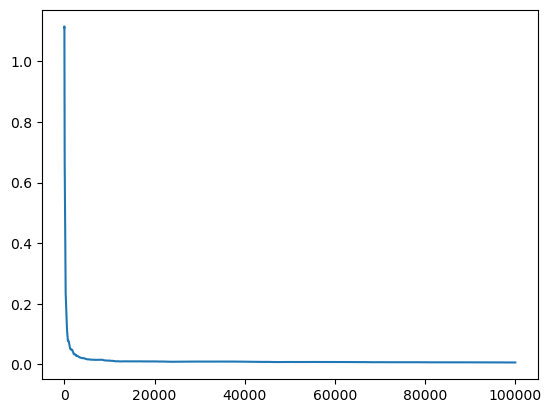

In [13]:
unadjusted_error_at_each_step = get_standardized_squared_error(
    unadjusted_samples[None, :, :], 
    f=model.sample_transformations["square"].fn,
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.mean
    )[0]

plt.plot(unadjusted_error_at_each_step[:])
plt.show()


In [ ]:
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')
# num_steps1 = 1000
num_adjusted_steps = 100
num_chains = 200
diagonal_preconditioning = True
print("running las")
sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning)
unadjusted_samples_gaussian, adjusted_samples_gaussian, infos_gaussian, num_steps_unadjusted_gaussian = sampler(model, key=jax.random.key(0))

running las
num_alba_steps: 10000
thinning_rate: 50
new_num_alba_steps: 200
params before alba tuning (Array(1.4142135, dtype=float32, weak_type=True), Array(1.0516049, dtype=float32, weak_type=True))
ess after alba (Array(1.4142135, dtype=float32, weak_type=True), Array(1.0516049, dtype=float32, weak_type=True), Array([71.10184 , 60.654648], dtype=float32))
thinning_rate 152
alg SamplingAlgorithm(init=<function as_top_level_api.<locals>.init_fn at 0x7f0514320180>, step=<function thin_algorithm.<locals>.step_fn at 0x7f051448a340>)


(100, 199, 2)
